In [65]:
import cv2
import numpy as np
from skimage.morphology import square, closing
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from matplotlib import pyplot as plt

def combined_segment_logo(image_path, otsu_range, canny_range):
    def segment_logo_canny(img, low_threshold, high_threshold):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # plt.imshow(gray, cmap='gray')
        # plt.show()
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        # plt.imshow(blurred, cmap='gray')
        # plt.show()
        edges = cv2.Canny(blurred, low_threshold, high_threshold)
        # plt.imshow(edges, cmap='gray')
        # plt.show()
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]
        # plt.imshow(cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3))
        # plt.show()
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
        # show currect mask
        # plt.imshow(mask, cmap='gray')
        # plt.show()
        background = np.full_like(img, (255, 255, 255), dtype=np.uint8)
        result = np.where(mask[..., None].astype(bool), img, background)
        # plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        # plt.show()
        return result

    def segment_logo_skimage(img, square_size):
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thresh = threshold_otsu(gray_image)
        # if square_size == 5:
        #     plt.imshow(gray_image > thresh, cmap='gray')
        #     plt.show()
        bw = closing(gray_image > thresh, square(square_size))
        # if square_size == 5:
        #     plt.imshow(bw, cmap='gray')
        #     plt.show()
        cleared = clear_border(bw)
        # if square_size == 5:
        #     plt.imshow(cleared, cmap='gray')
        #     plt.show()
        label_image = label(cleared)
        regions = regionprops(label_image)
        if regions:  # Check if the list of regions is not empty
            logo_region = max(regions, key=lambda r: r.area)
            # plot largest region
            # if square_size == 5:
            #     plt.imshow(label_image == logo_region.label)
            #     plt.show()
            logo_mask = np.zeros_like(gray_image)
            minr, minc, maxr, maxc = logo_region.bbox
            logo_mask[minr:maxr, minc:maxc] = label_image[minr:maxr, minc:maxc] == logo_region.label
            logo = np.zeros_like(img)
            for i in range(3):
                logo[:, :, i] = img[:, :, i] * logo_mask
            background_color = [255, 255, 255]
            for i in range(3):
                logo[:, :, i][logo_mask == 0] = background_color[i]
            # if square_size == 5:
            #     plt.imshow(cv2.cvtColor(logo, cv2.COLOR_BGR2RGB))
            #     plt.show()
            #     #plt maks
            #     plt.imshow(logo_mask, cmap='gray')
            #     plt.show()
        else:
            # Handle the case where no regions are found. You might want to return the original image,
            # a blank image, or continue to the next iteration.
            logo = np.zeros_like(img) + 255  # Create a white blank image as a placeholder
        
        return logo

    image = cv2.imread(image_path)

    results = []
    for square_size in otsu_range:
        logo_otsu = segment_logo_skimage(image, square_size)
        results.append((logo_otsu, 'otsu', square_size))

    for low_threshold, high_threshold in canny_range:
        logo_canny = segment_logo_canny(image, low_threshold, high_threshold)
        results.append((logo_canny, 'canny', (low_threshold, high_threshold)))

    return results

# Placeholder for the image path
image_paths = [
    './Original_imgs/JPG/handbag1.jpg',
    './Original_imgs/JPG/handbag2.jpg',
    './Original_imgs/JPG/handbag3.jpg',
    './Original_imgs/JPG/handbag4.jpg',
    './Original_imgs/JPG/handbag7.jpg',
    './Original_imgs/JPG/handbag8.jpg',
]

# Define ranges for Otsu and Canny methods
otsu_range = range(1, 26)  # Square sizes from 1 to x
canny_range = [(i, i+100) for i in range(0, 501, 20)]  # Canny thresholds from 0 to x with a step of y


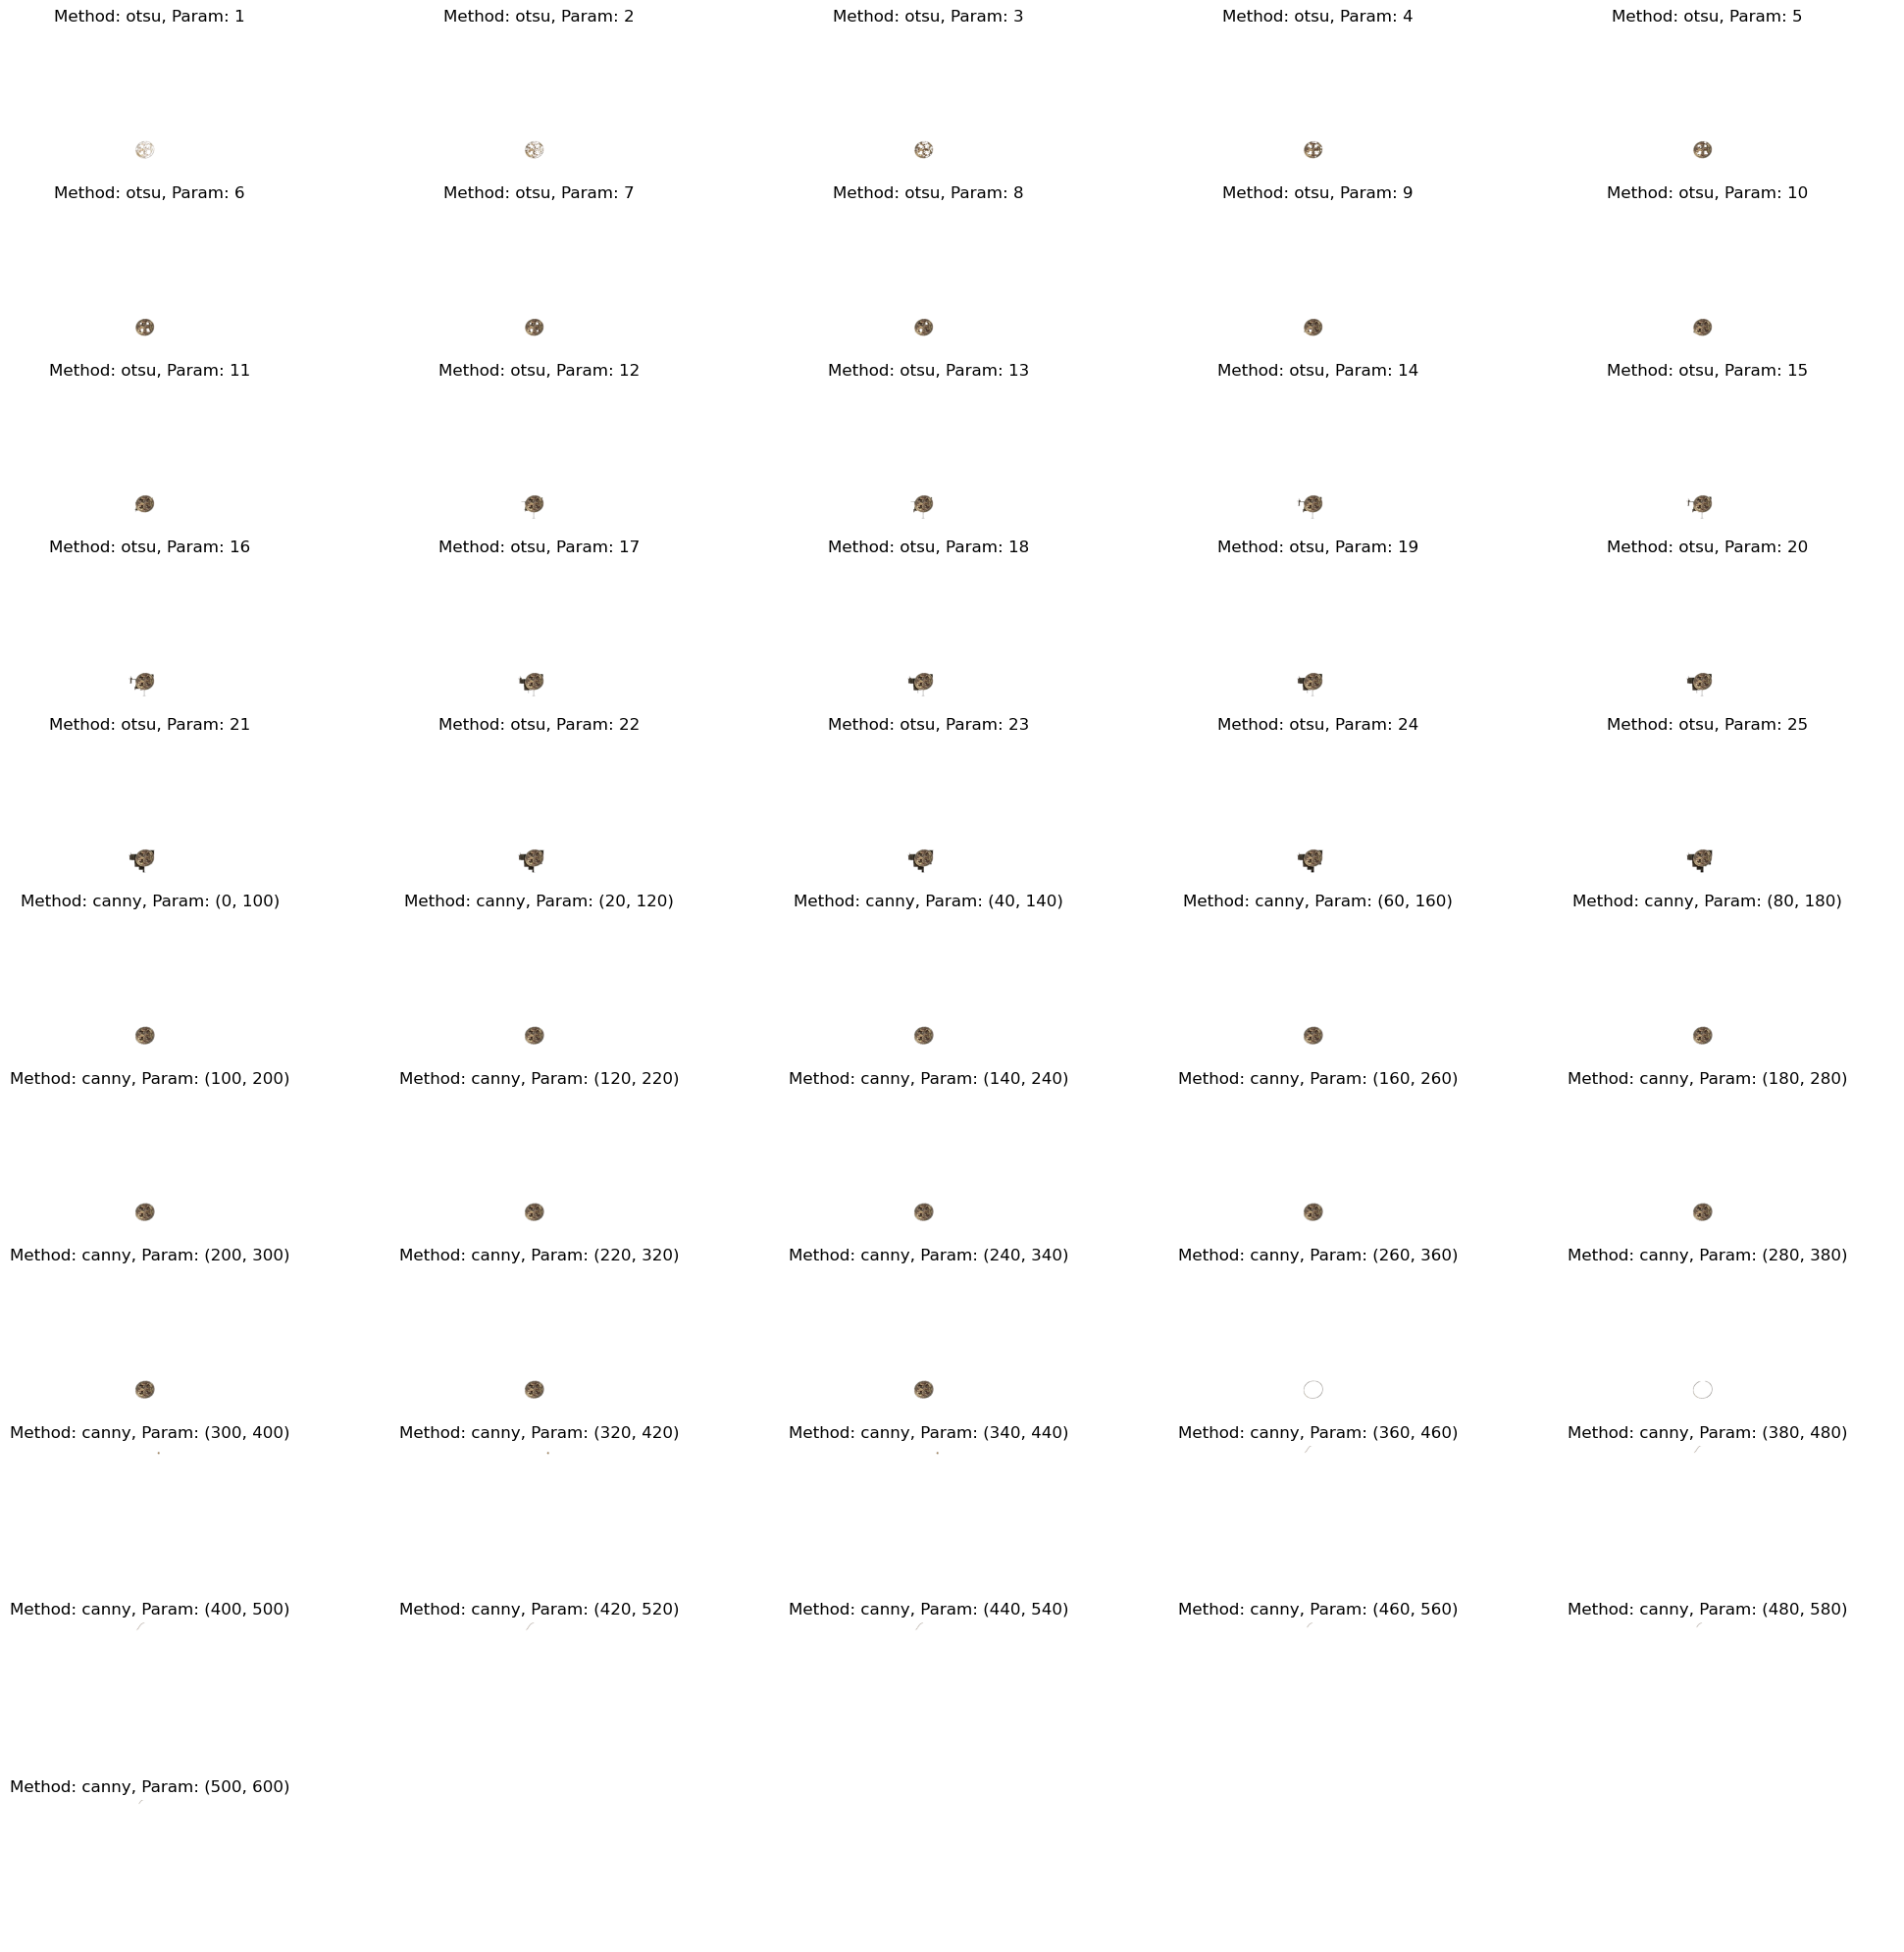

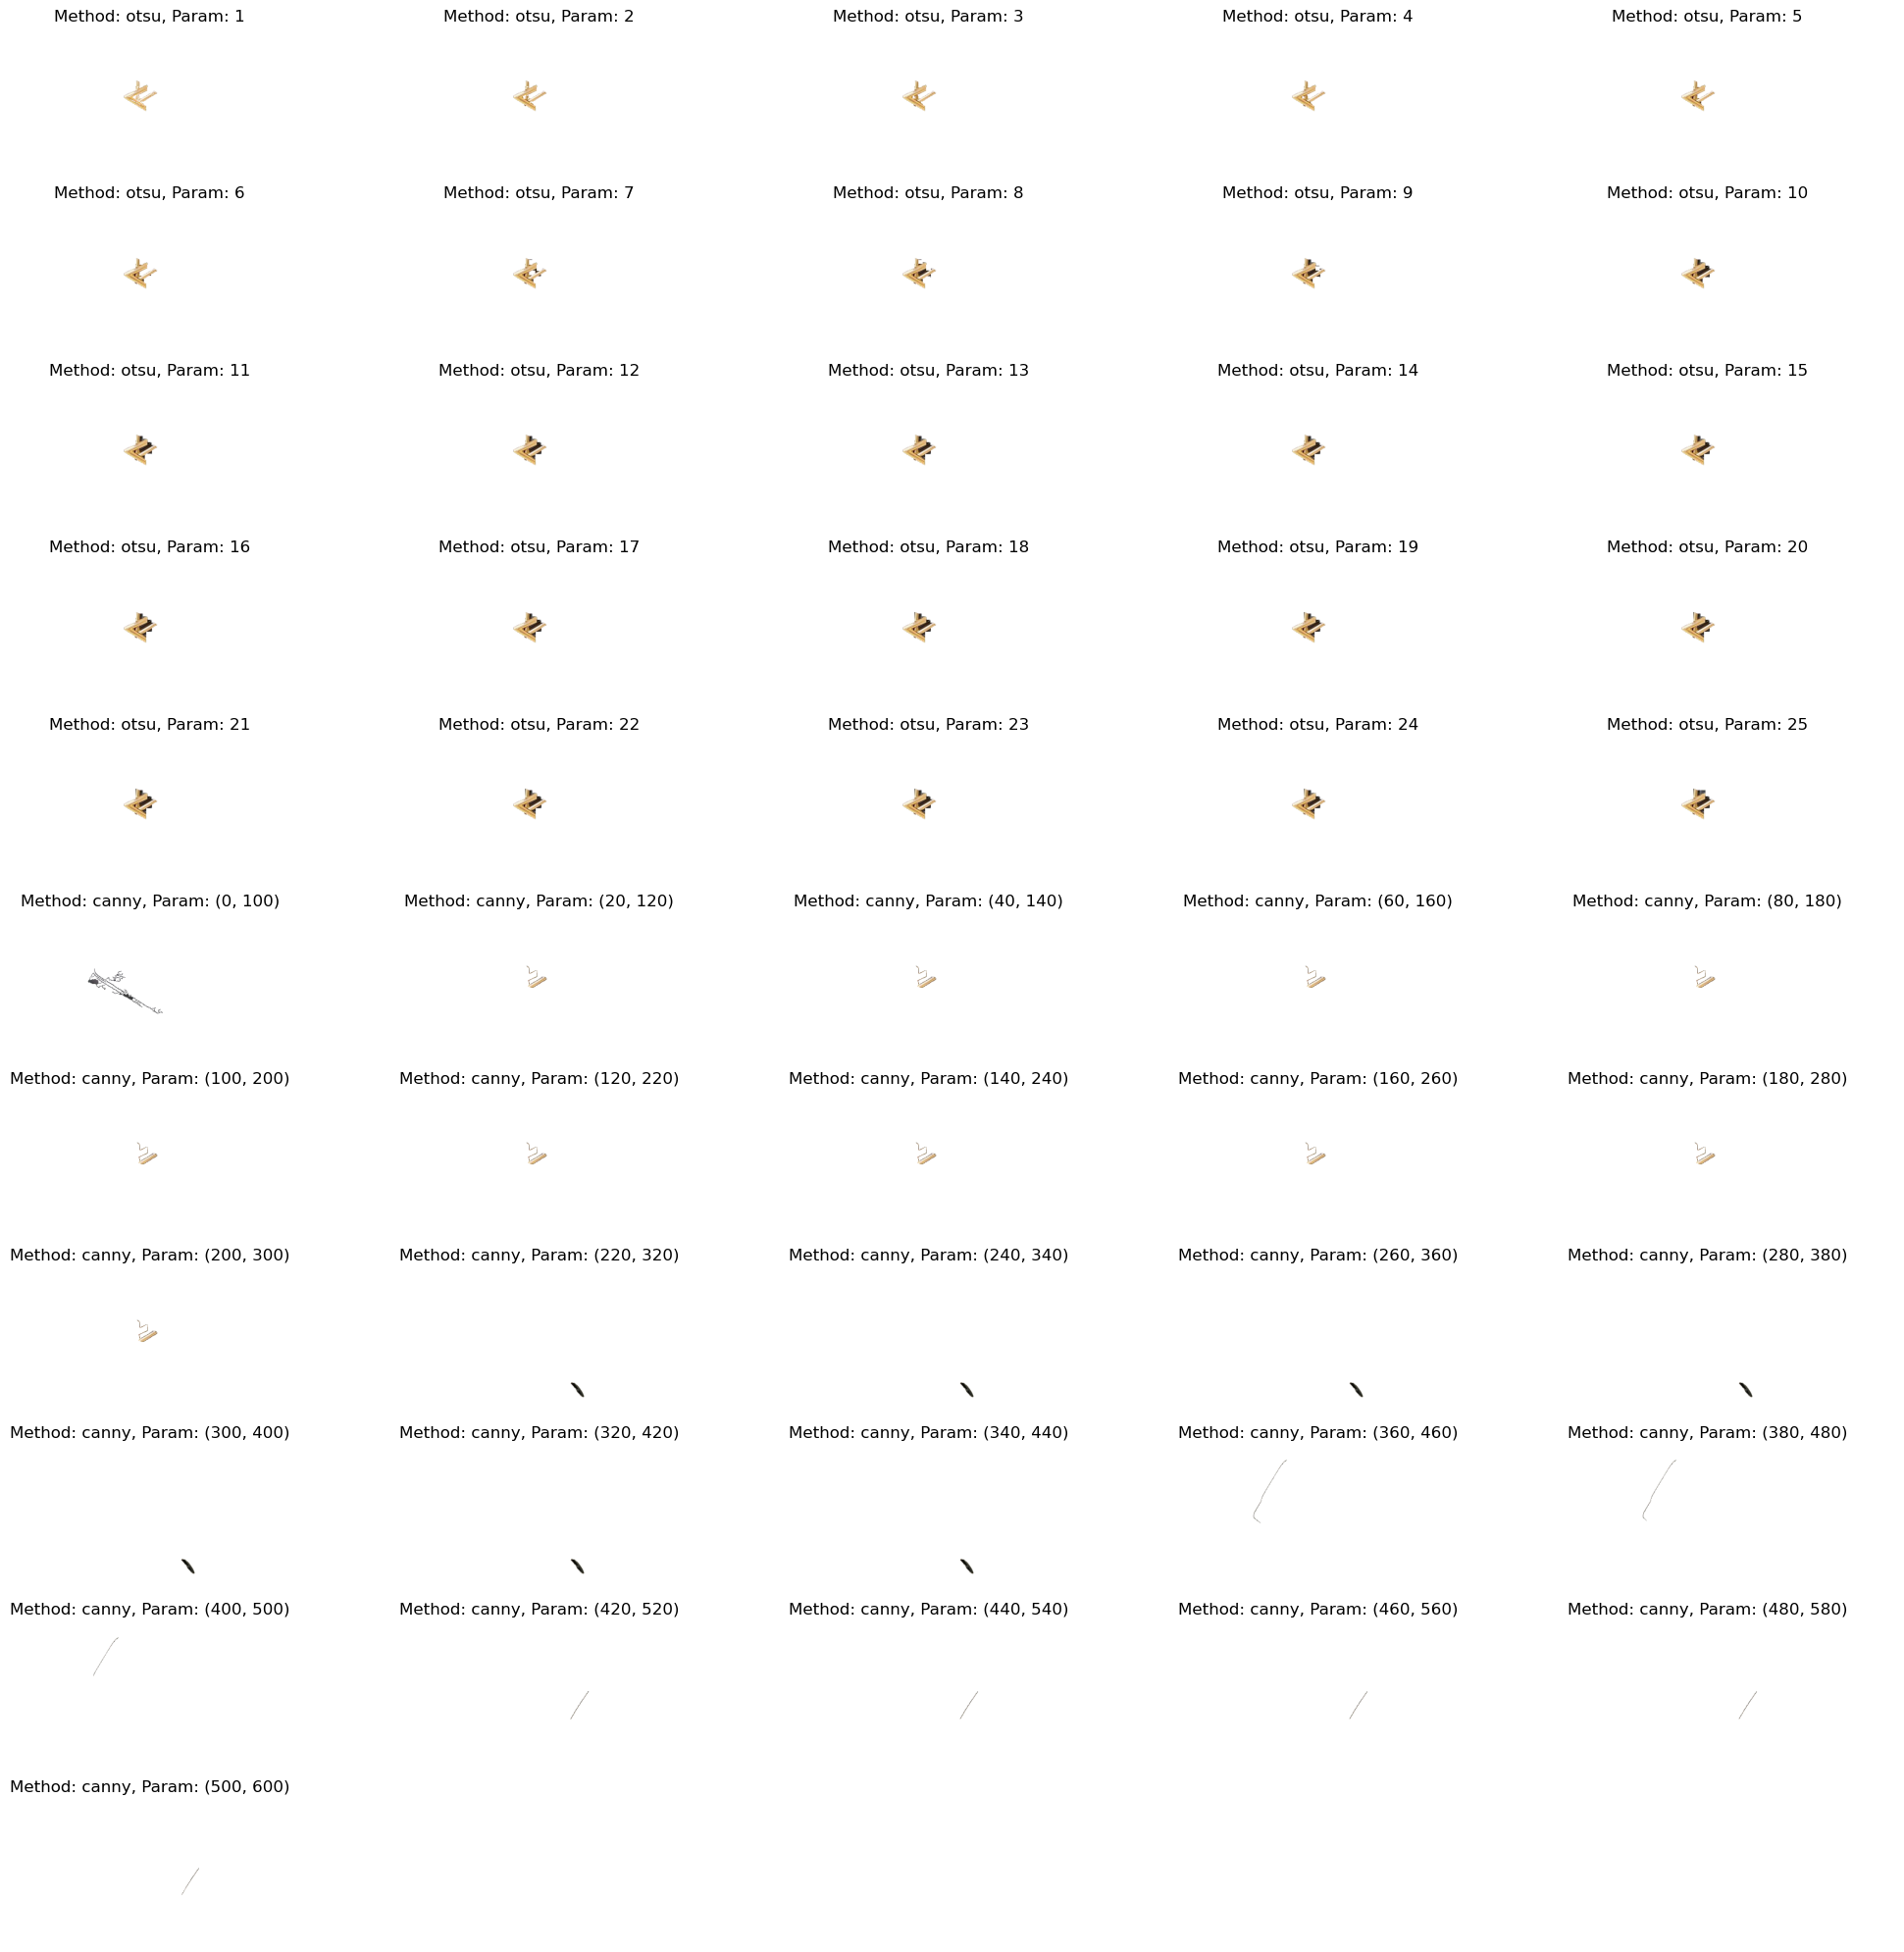

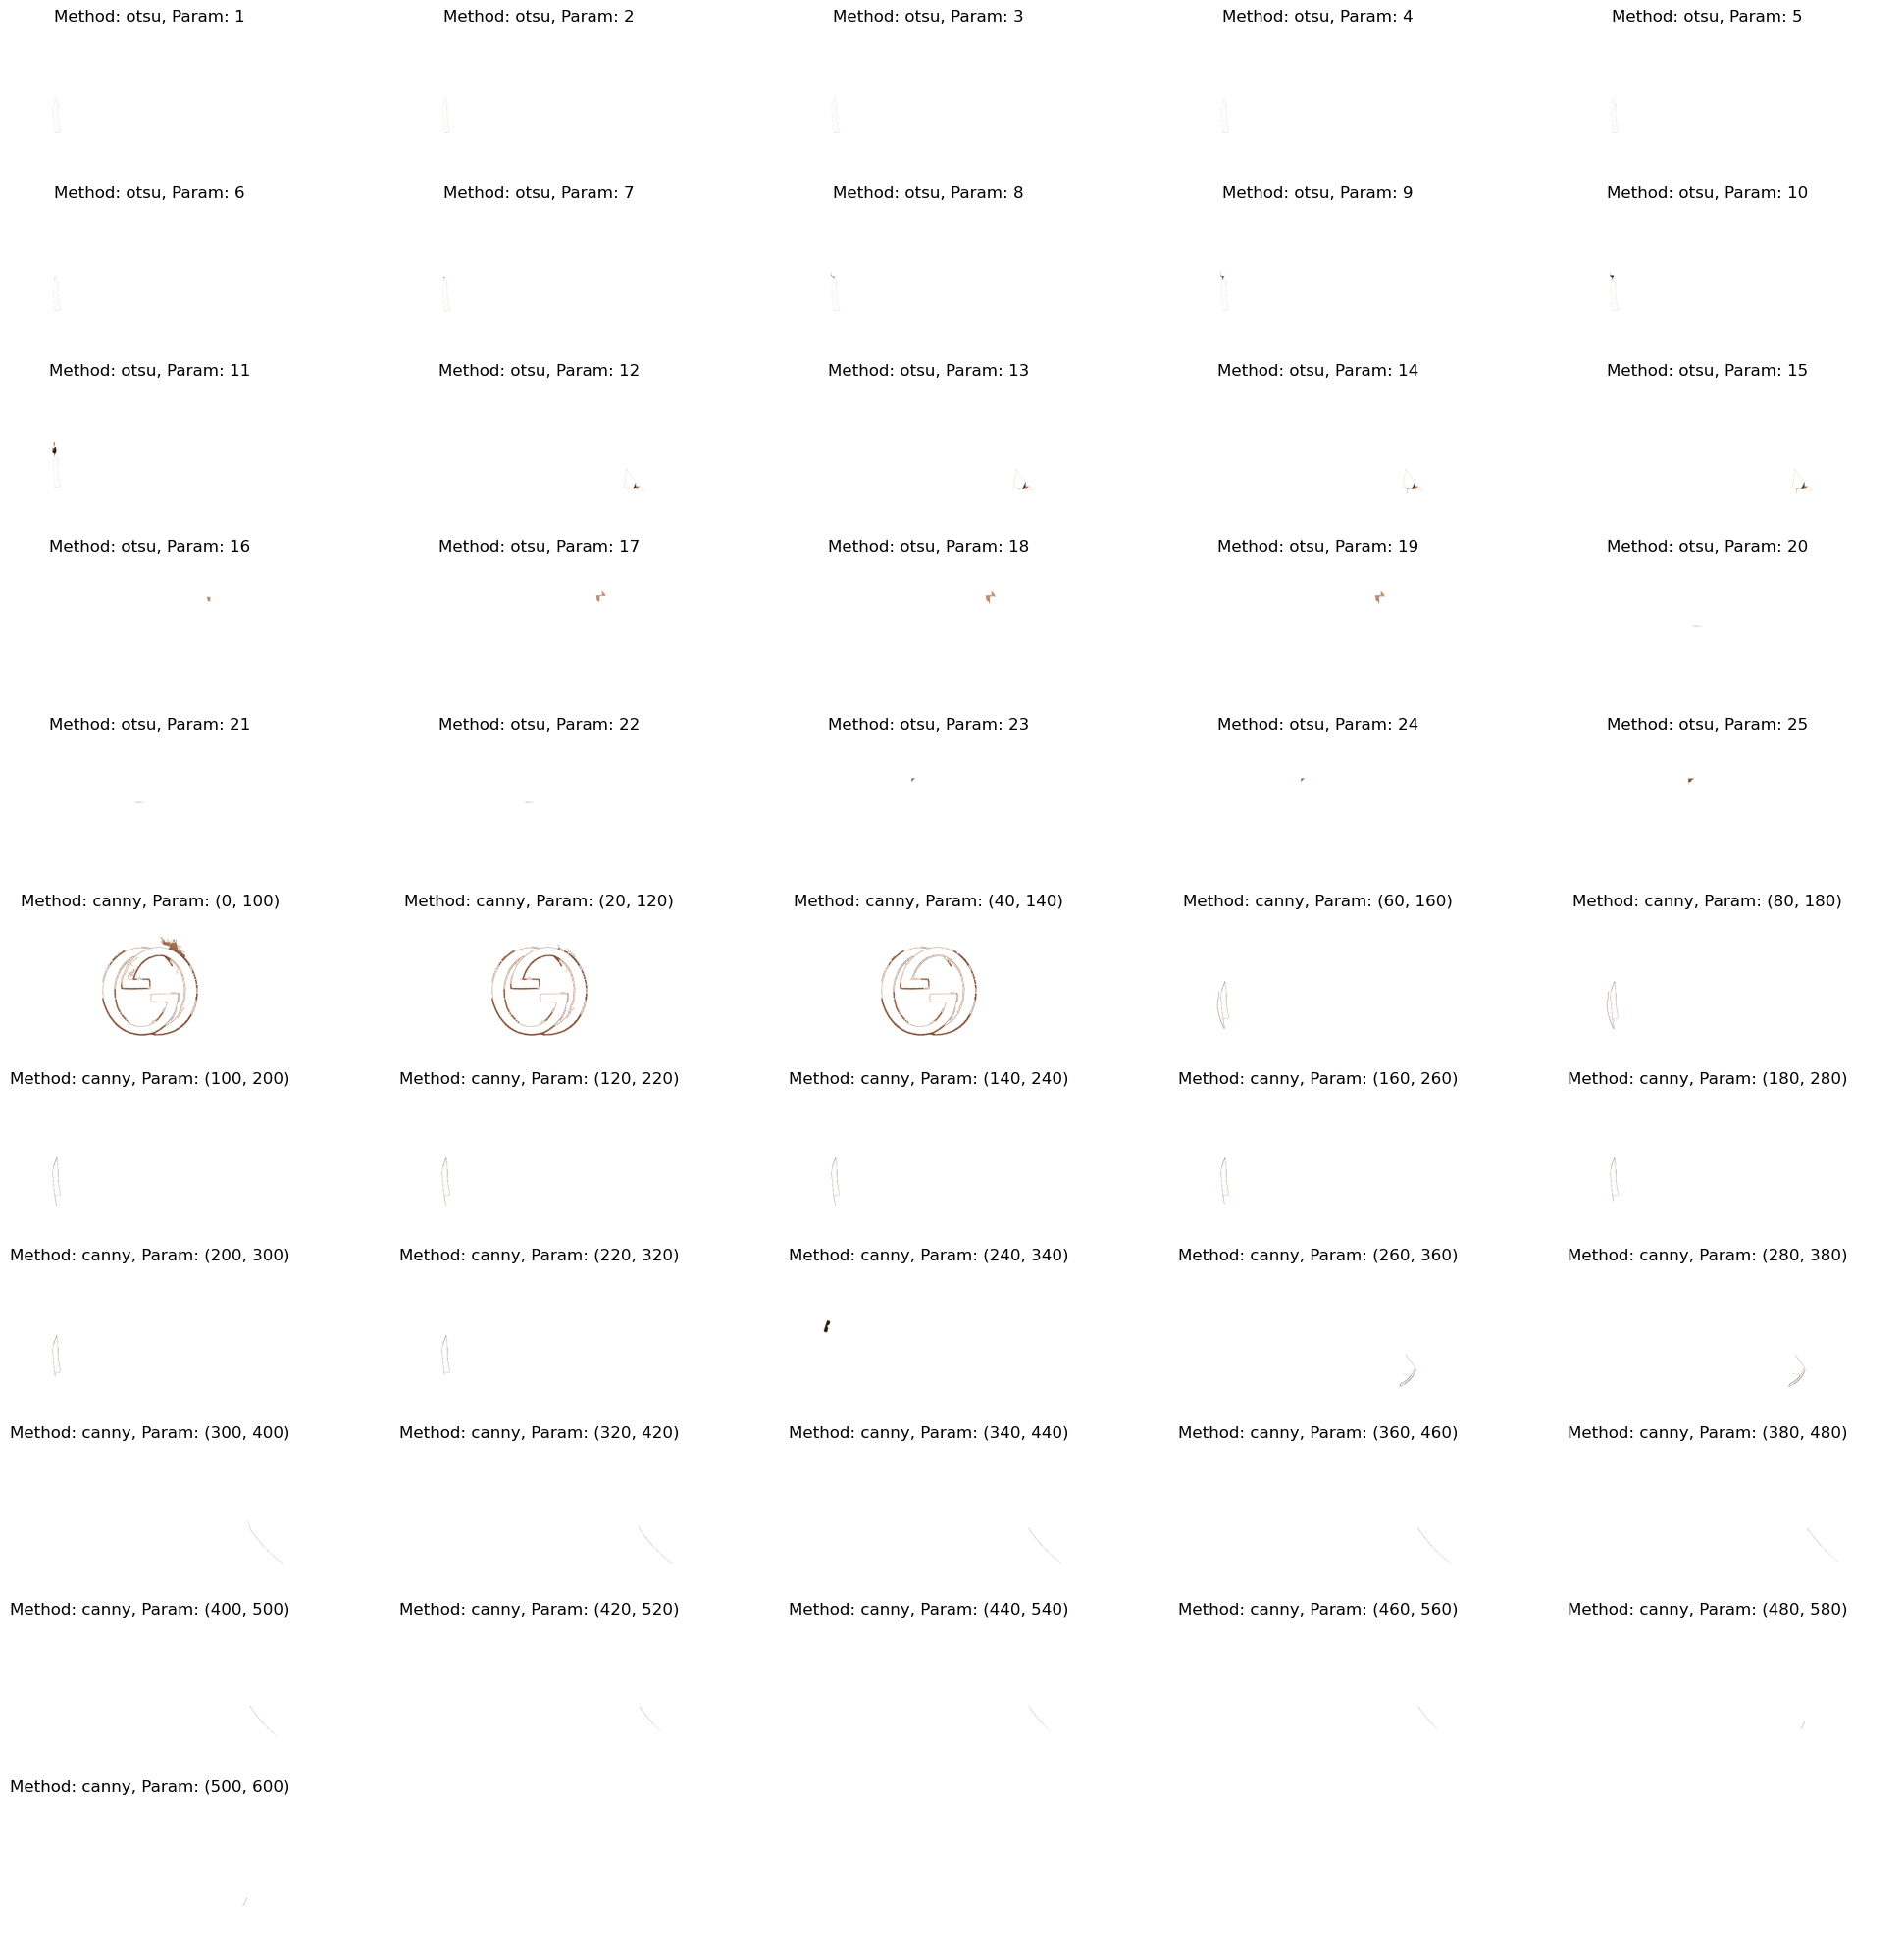

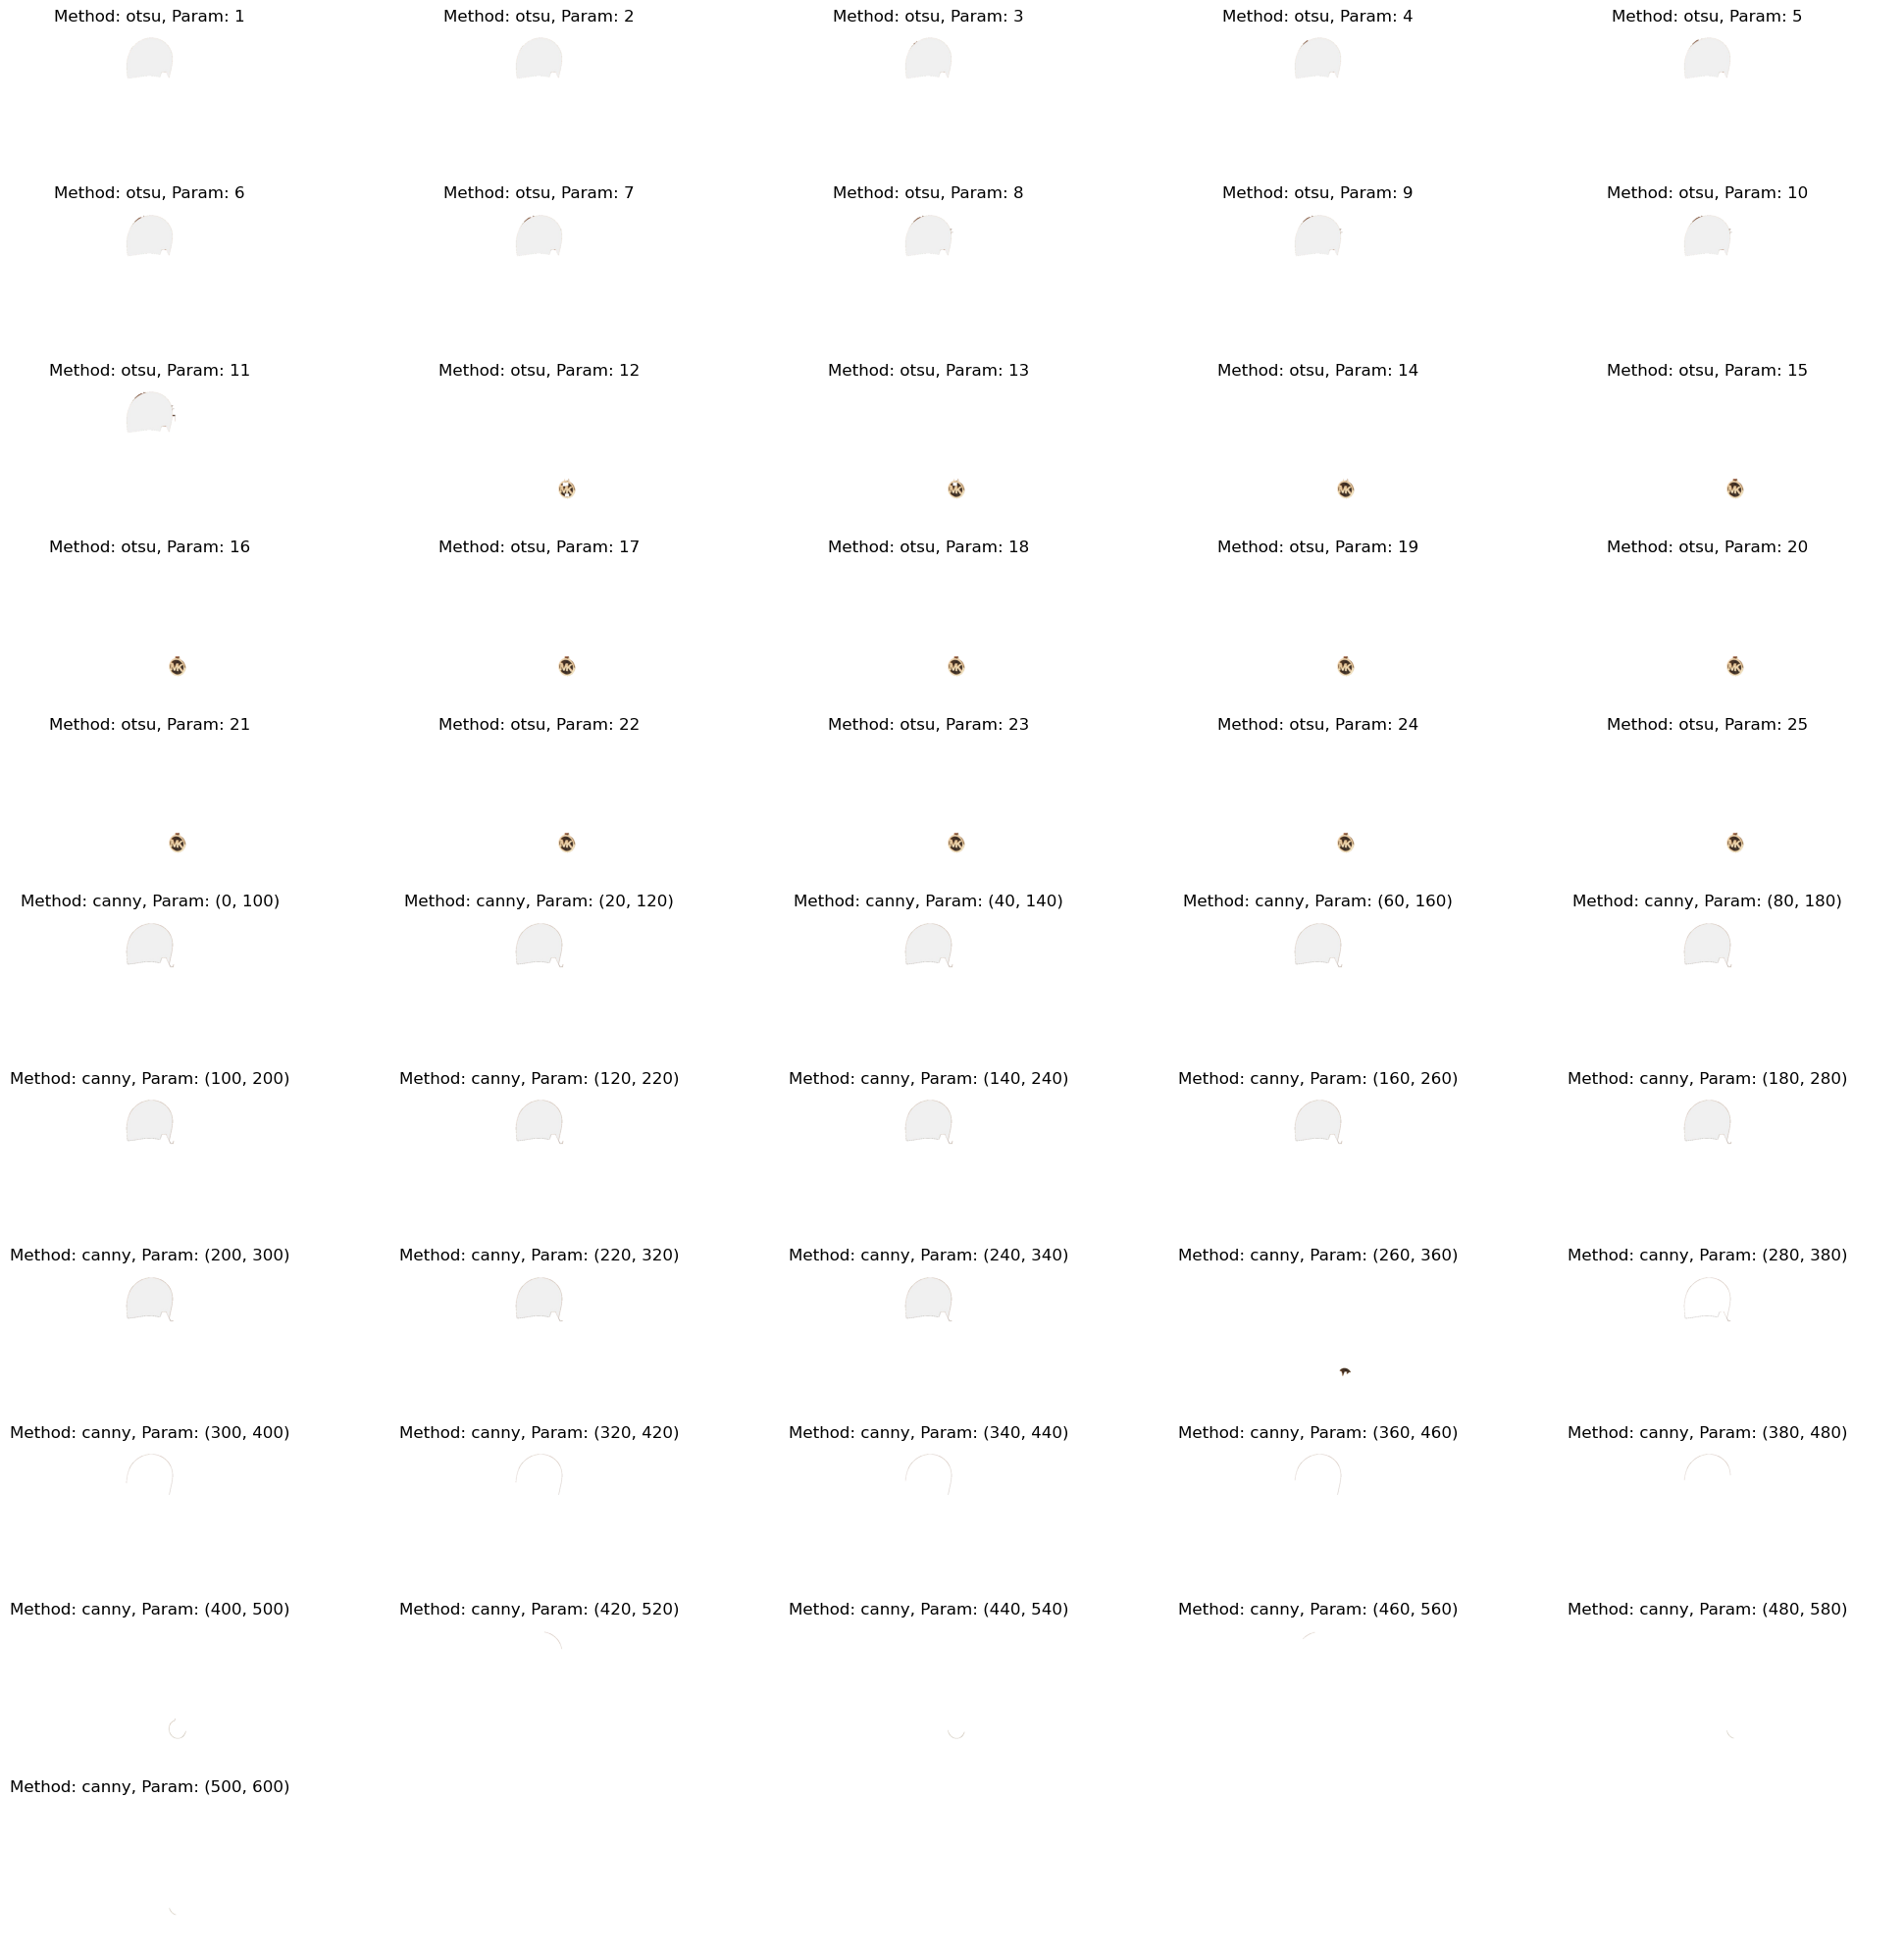

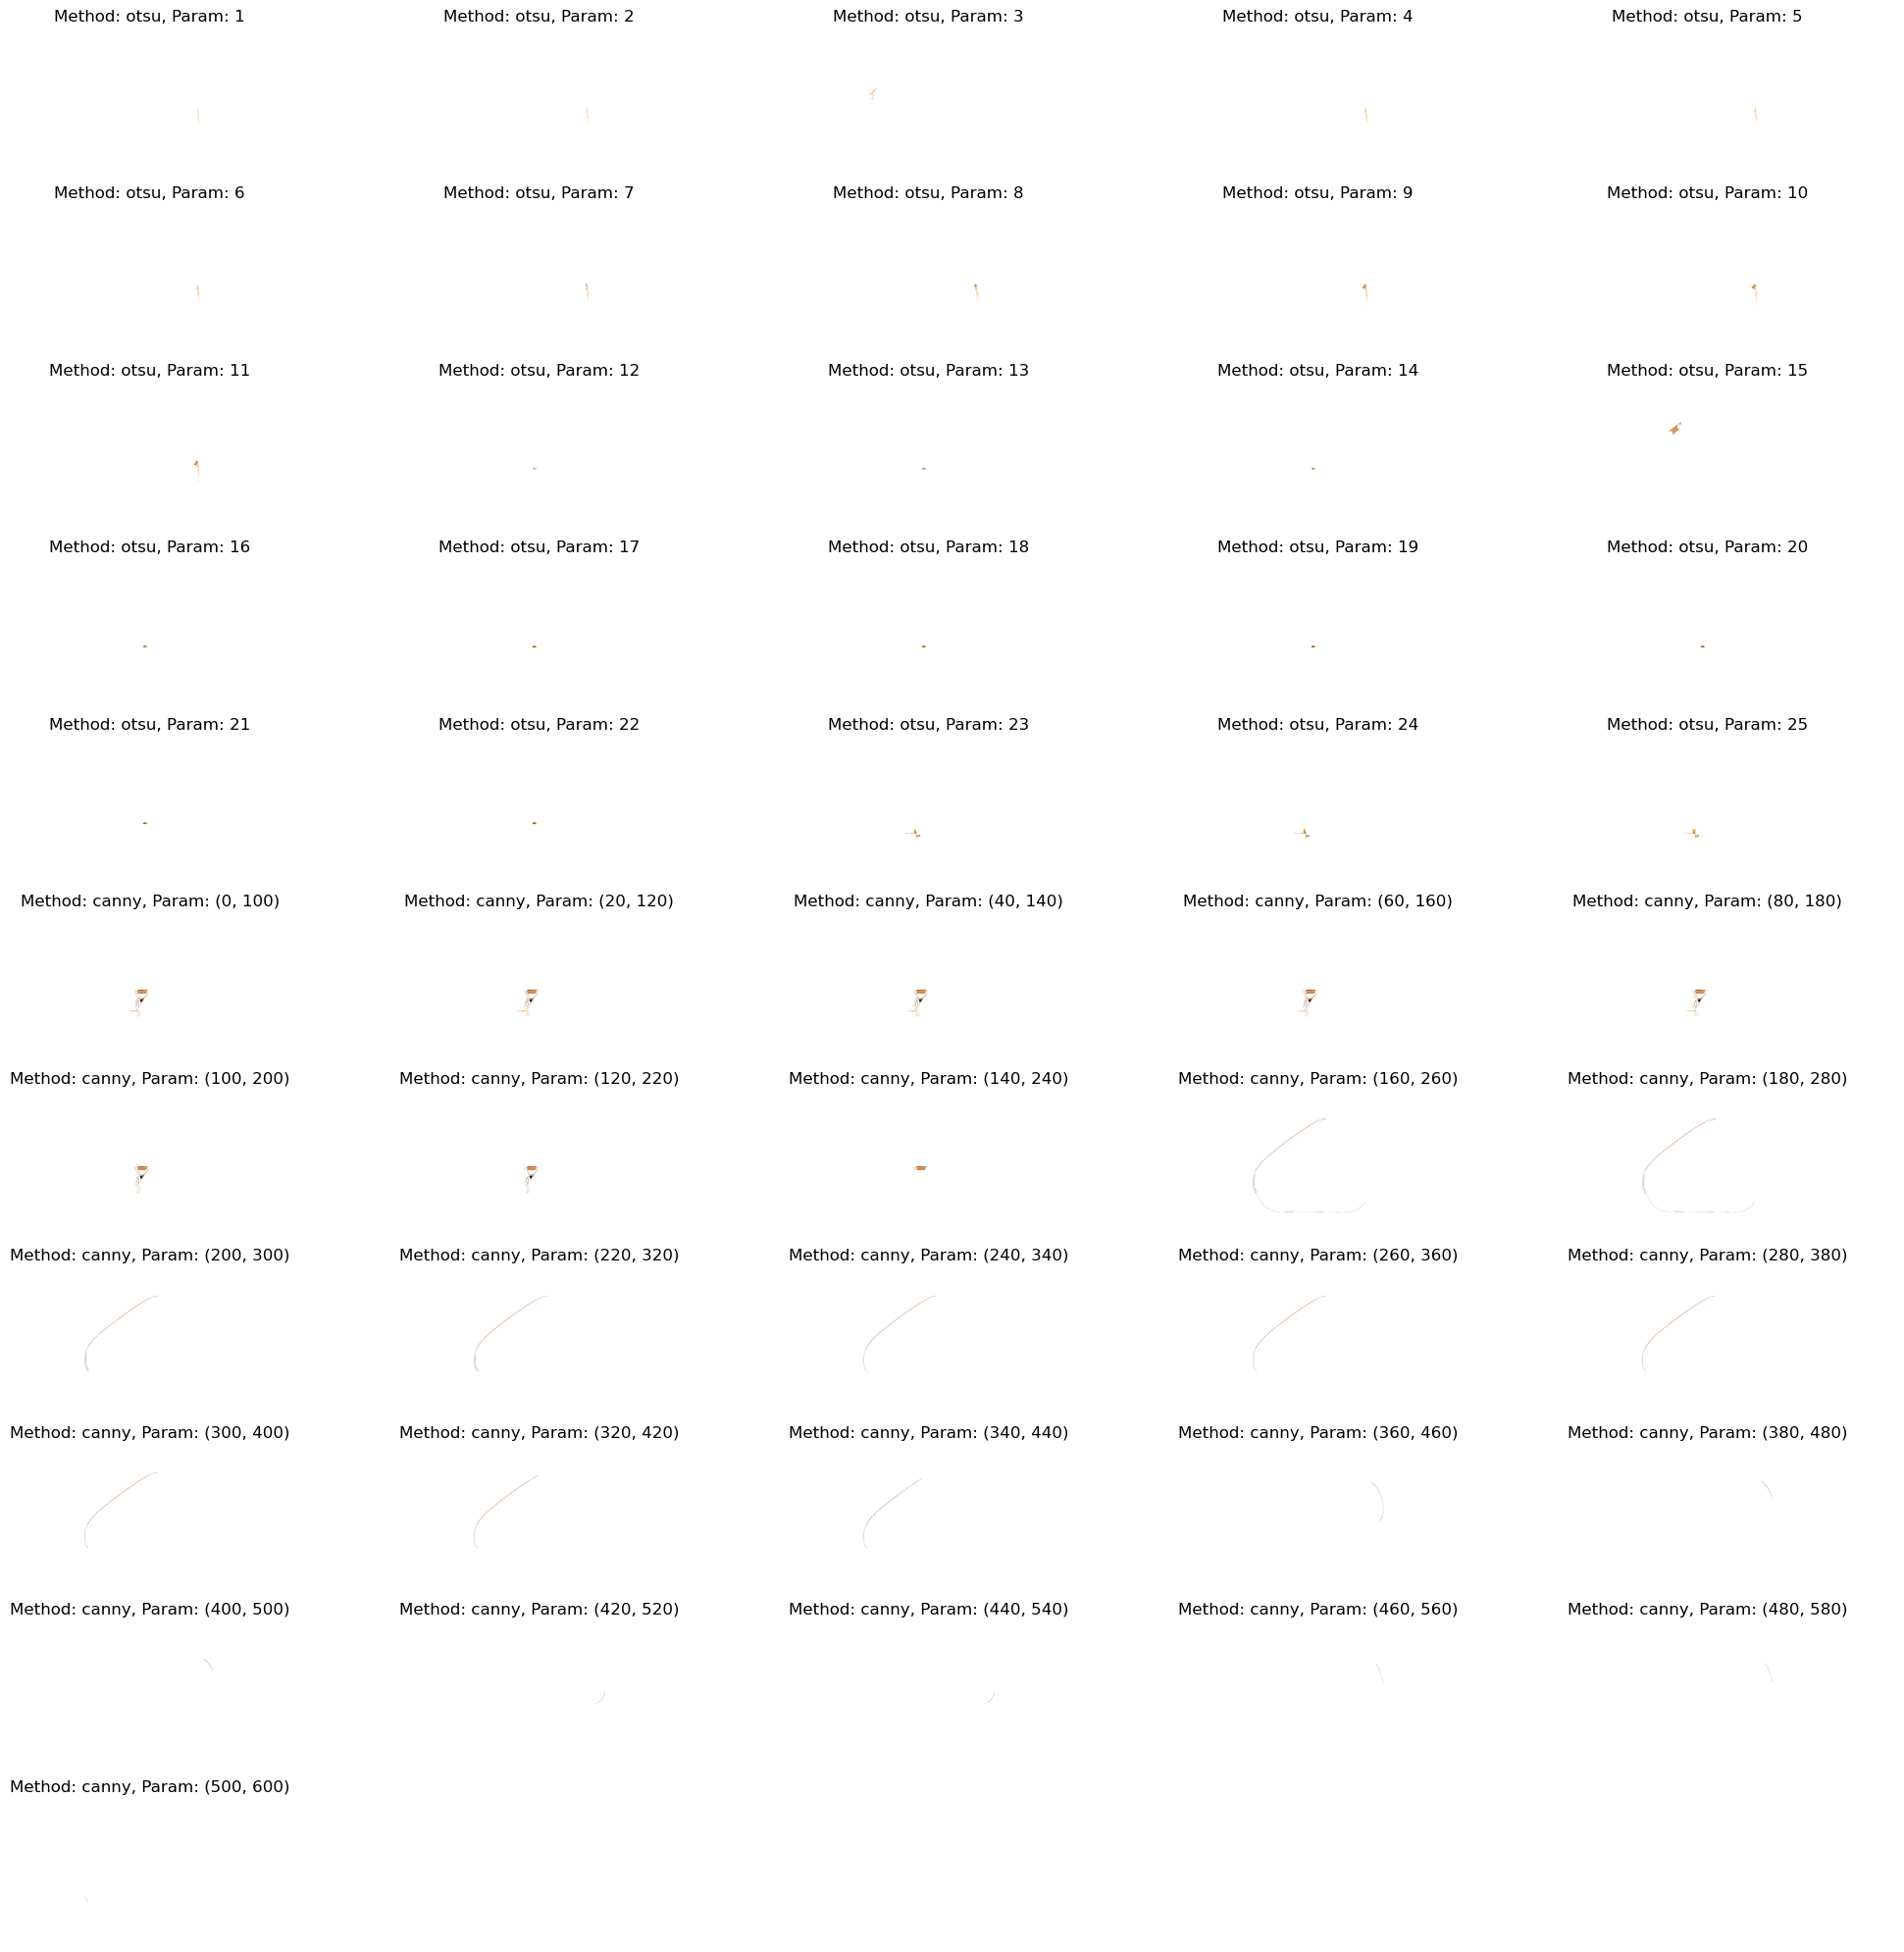

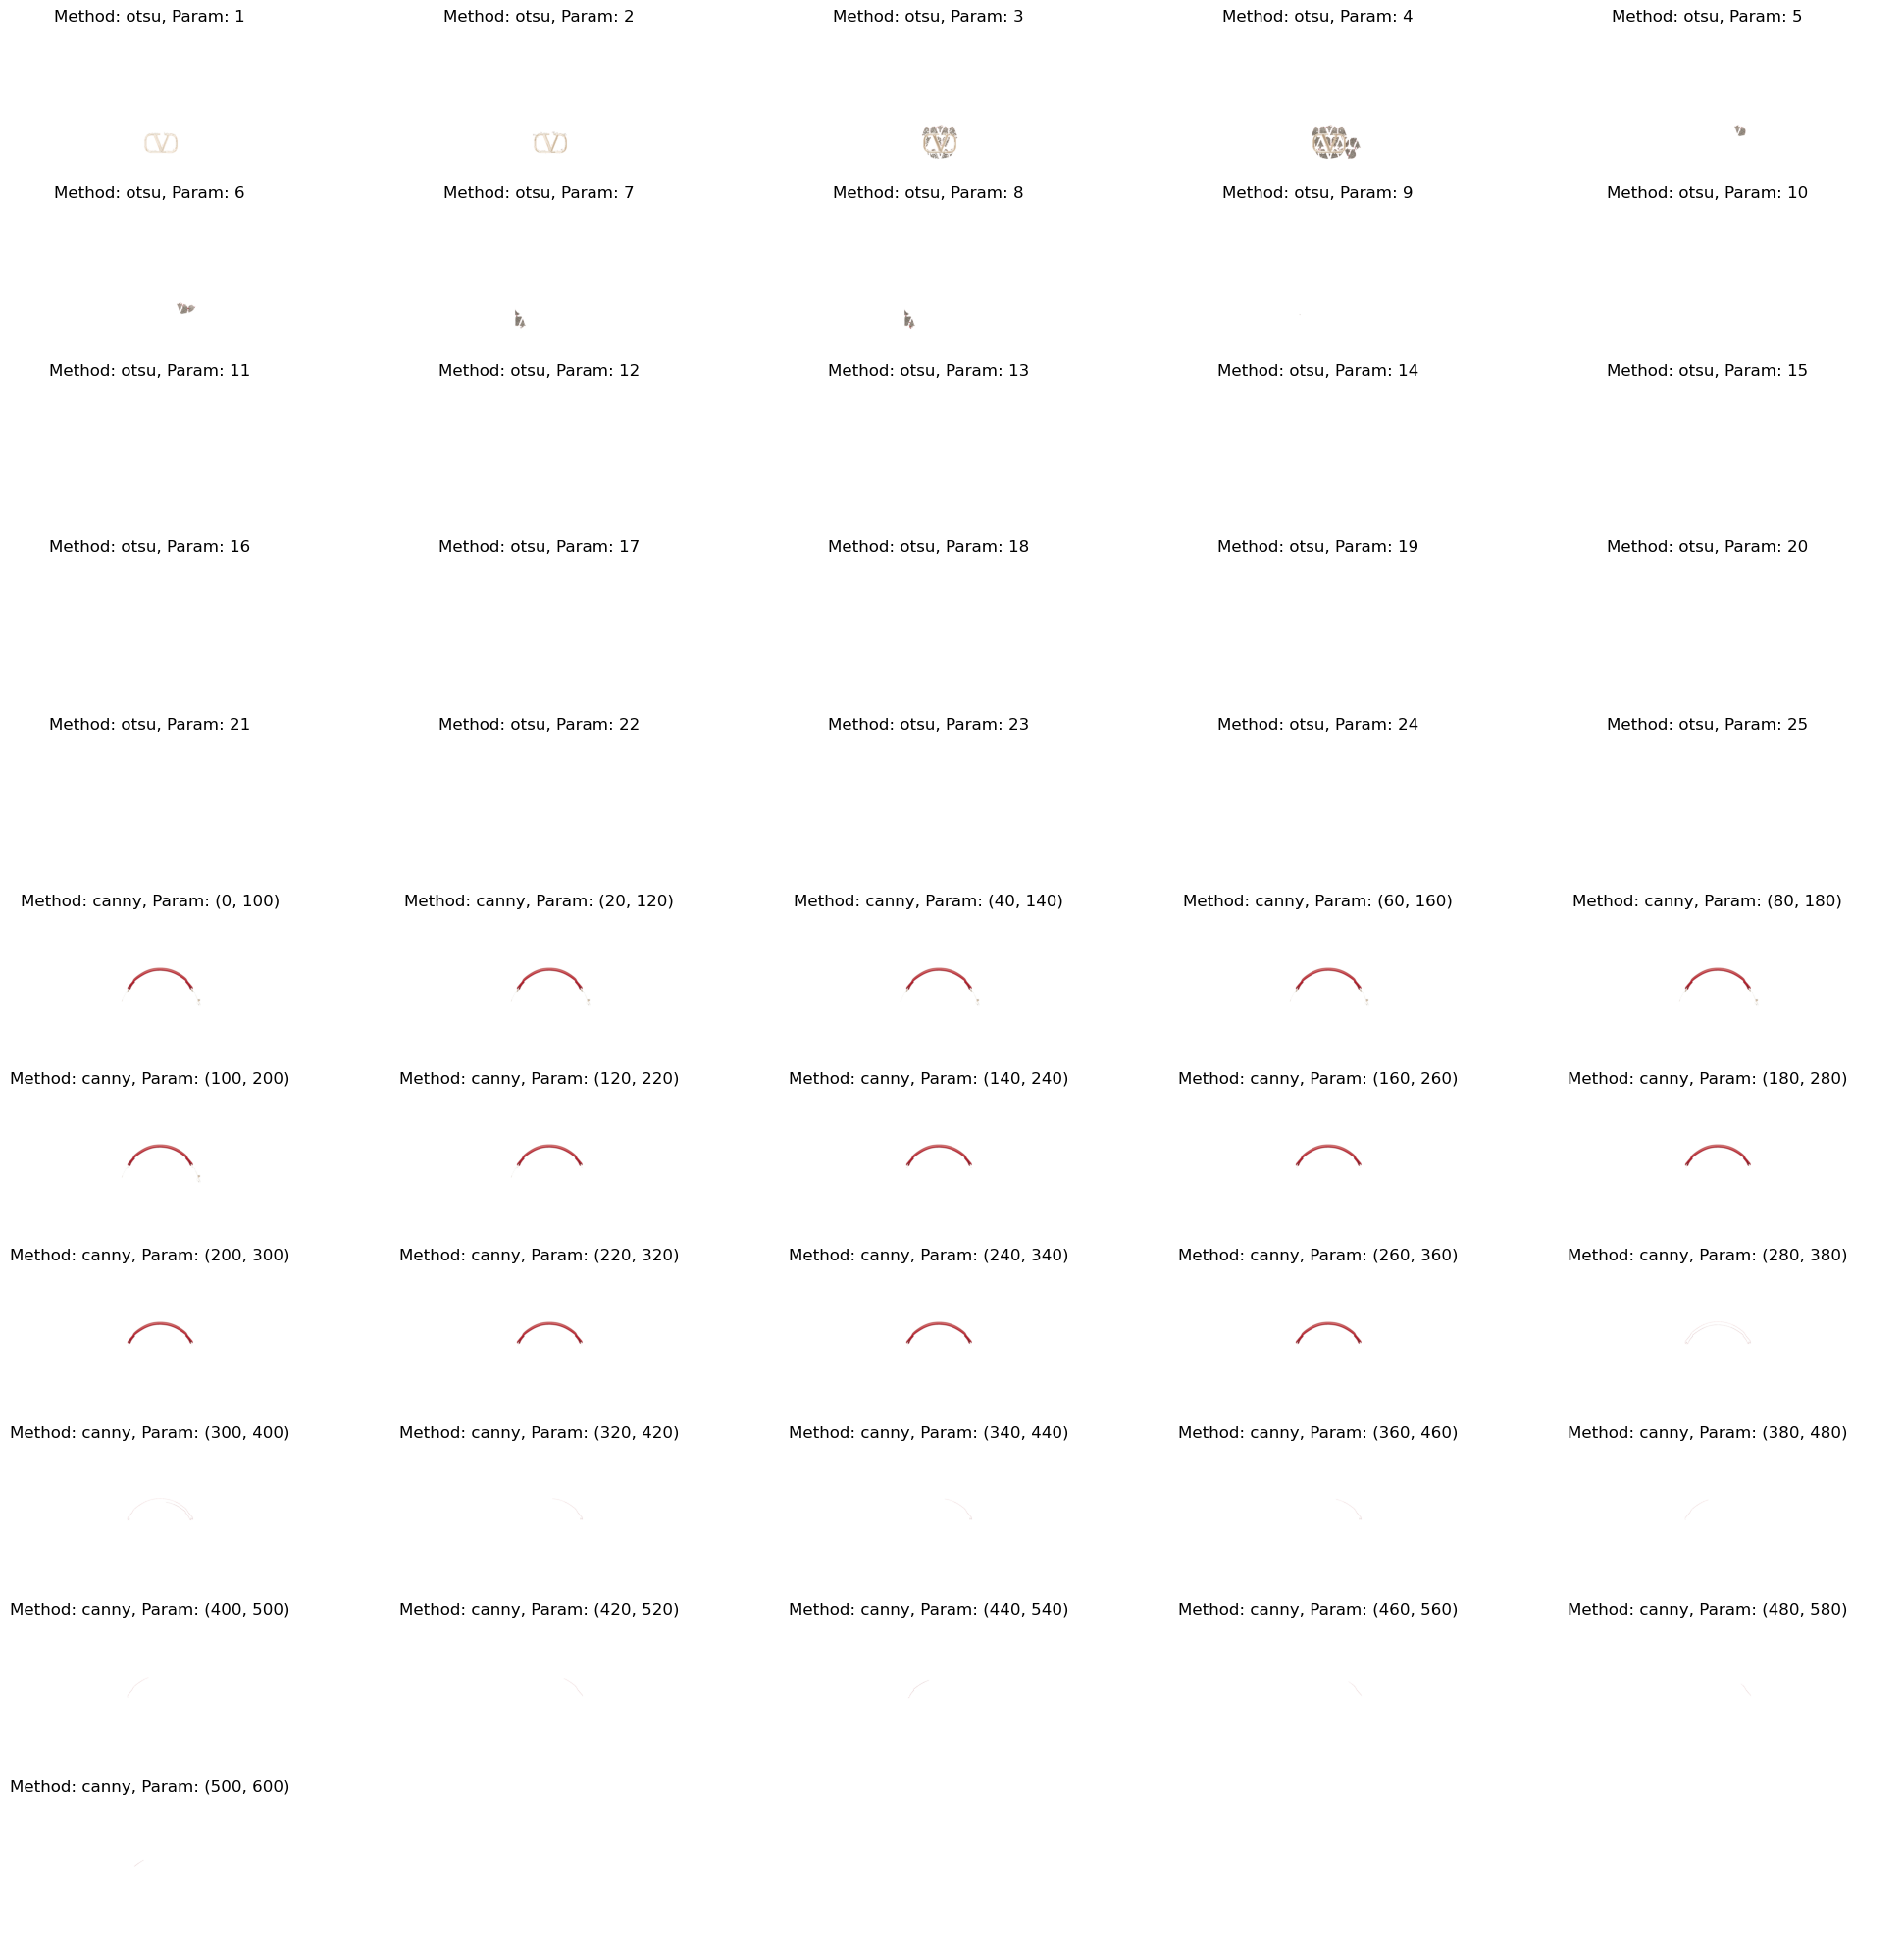

In [66]:
# Displaying the results
num_otsu = len(otsu_range)
num_canny = len(canny_range)
total = num_otsu + num_canny
for image in image_paths:
    segmented_logos = combined_segment_logo(image, otsu_range, canny_range)   
    # Set up the matplotlib figure and axes, based on the total number of images
    fig, axes = plt.subplots(total // 5 + (total % 5 > 0), 5, figsize=(20, 20))
    axes = axes.flatten()

    for i, (logo, method, param) in enumerate(segmented_logos):
        axes[i].imshow(cv2.cvtColor(logo, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f'Method: {method}, Param: {param}')
        axes[i].axis('off')

    # Hide any remaining subplots that aren't used
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [67]:
import os
def create_dir_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
base_save_dir = './segmented_images'
create_dir_if_not_exists(base_save_dir)

# Define ranges for Otsu and Canny methods
otsu_range = range(1, 26)  # Square sizes from 1 to x
canny_range = [(i, i+100) for i in range(0, 501, 20)]  # Canny thresholds from 0 to x with a step of y

for image_path in image_paths:
    segmented_logos = combined_segment_logo(image_path, otsu_range, canny_range)
    image_name = os.path.basename(image_path).split('.')[0]

    for logo, method, param in segmented_logos:
        # Create subdirectories for each method
        method_dir = os.path.join(base_save_dir, method)
        create_dir_if_not_exists(method_dir)

        # Define the filename
        if method == 'otsu':
            filename = f"{image_name}_otsu_{param}.jpg"
        else:  # canny
            filename = f"{image_name}_canny_{param[0]}_{param[1]}.jpg"

        # Save the image
        save_path = os.path.join(method_dir, filename)
        cv2.imwrite(save_path, logo)

        print(f"Saved: {save_path}")

# ... [Your existing code for displaying the results, if needed] ...

Saved: ./segmented_images\otsu\handbag1_otsu_1.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_2.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_3.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_4.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_5.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_6.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_7.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_8.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_9.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_10.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_11.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_12.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_13.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_14.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_15.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_16.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_17.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_18.jpg
Saved: ./segmented_images\otsu\handbag1_otsu_19.jpg
Saved: ./segmented_im